Итак, что нужно сделать: у нас есть данные АА-теста с '2023-06-23' по '2023-06-29'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [6]:
%pip install pandahouse
%pip install seaborn
%pip install swifter
%pip install scipy

ERROR: Could not find a version that satisfies the requirement hashlib (from versions: 20081119)
ERROR: No matching distribution found for hashlib
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import pandahouse 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import swifter
import hashlib
from scipy import stats
%matplotlib inline

In [99]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '********',
    'user': '********',
    'database': 'simulator_20230720'
}

q = """
SELECT  DISTINCT user_id ,
        exp_group,
        sum(action = 'like') likes,
        sum(action = 'view') views,
        likes/views ctr
FROM simulator_20230720.feed_actions 
WHERE toDate(time) >= '2023-06-23' AND toDate(time) <= '2023-06-29'
GROUP by exp_group, user_id
HAVING exp_group in (2, 3)
"""

users_df = pandahouse.read_clickhouse(q,  connection=connection)
#users_df = pandahouse.read_clickhouse(q, index_col='user_id', connection=connection)

In [148]:
users_df.head(5)

,user_id,exp_group,likes,views,ctr
0,115383,3,38,248,0.153226
1,10326,3,24,132,0.181818
2,123580,3,25,122,0.204918
3,131473,2,19,98,0.193878
4,23985,2,12,44,0.272727


In [149]:
print(f'Количественное соотношение юзеров в интересующих группах (2, 3):')
users_df.groupby('exp_group').count()

Количественное соотношение юзеров в интересующих группах (2, 3):


,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


Сделаем отдельно одну итерацию симуляции АА-теста, чтобы убедиться в работе алгоритма.

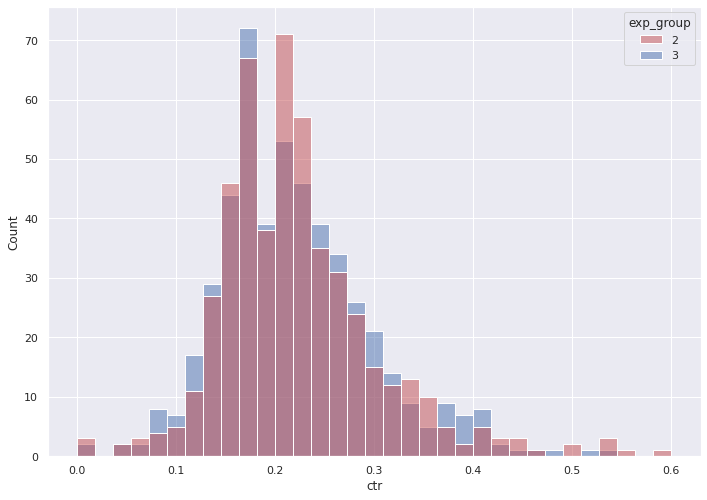

In [117]:
# Сформируем по одной подвыборке из групп 2 и 3 размером 500 без возврата
ctr_2 = users_df[users_df['exp_group'] == 2].ctr.sample(500, replace=False)
ctr_3 = users_df[users_df['exp_group'] == 3].ctr.sample(500, replace=False)

# Нарисуем ctr для подвыборок 

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = pd.concat([users_df[['exp_group', 'ctr']].loc[ctr_2.index],
                                        users_df[['exp_group', 'ctr']].loc[ctr_3.index]], axis=0), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Подвыборки наслаиваются, в целом, хорошо повторяют друг друга. Убедимся в этом численно. 

In [124]:
t_test = stats.ttest_ind(ctr_2,
                         ctr_3,
                         equal_var=False)
t_test

Ttest_indResult(statistic=0.5464432999527556, pvalue=0.5848835384995946)

Проведем 10000 АА-тестов

In [142]:
n = 10000
t_test = np.zeros([n, 2])
for i in range(0, n):
    ctr_2 = users_df[users_df['exp_group'] == 2].ctr.sample(500, replace=False)
    ctr_3 = users_df[users_df['exp_group'] == 3].ctr.sample(500, replace=False)

    t_test[i, 0], t_test[i, 1] = stats.ttest_ind(ctr_2, ctr_3, equal_var=False)

Распредление p-value по итогам тестов

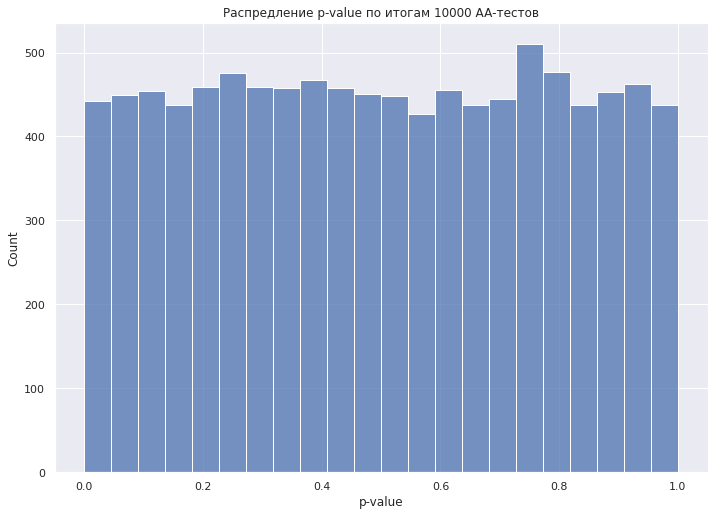

In [153]:
groups = sns.histplot(data = t_test[:, 1])
plt.title('Распредление p-value по итогам 10000 AA-тестов')
plt.xlabel('p-value')
plt.show()

In [159]:
print(f'По итогам тестирования {sum(t_test[:, 1] <= 0.05) / n * 100:.2f}% значений p-values <= 0.05')


По итогам тестирования 4.76% значений p-values <= 0.05


## Вывод:
По итогам проведения 10000 AA-тестов на подвыборках из 500 элементов без вовзрата из двух интересующих групп (2 и 3) видим, что статистически значимые различия между CTR в группах 2 и 3 встречаются лишь в 4.76% случаев, что является удовлетворительным значением. Поэтому можно считать нашу систему сплитования корректной.
